[View in Colaboratory](https://colab.research.google.com/github/ale93111/Unet_dsb2018/blob/master/Unet_weighted_valid_dsb2018.ipynb)

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [2]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pwd

/content


In [0]:
#!fusermount -u drive
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/kaggle/Unet_dsb2018")

In [4]:
#!pip install --upgrade pip
!pip install tqdm
!pip install tensorflow
!pip install keras
!pip install imgaug

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 563kB 6.0MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /content/.cache/pip/wheels/31/48/c8/ca3345e8582a078de94243996e148377ef66fdb845557bae0b
Successfully built imgaug


In [5]:
import os

NAME = 'bowl'

# Root directory of the project
ROOT_DIR = os.getcwd()

print(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#Dataset directory
dataset_path = os.path.join(ROOT_DIR, "RCNN_dataset_512_labels")

/content/drive/kaggle/Unet_dsb2018


In [0]:
import numpy as np
from functools import partial, update_wrapper

#partial name fix
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

def pad2n(image,npad=32):
    h, w = image.shape[:2]
    if h % npad > 0:
        max_h = h - (h % npad) + npad
        top_pad = (max_h - h) // 2
        bottom_pad = max_h - h - top_pad
    else:
        top_pad = bottom_pad = 0
    # Width
    if w % npad > 0:
        max_w = w - (w % npad) + npad
        left_pad = (max_w - w) // 2
        right_pad = max_w - w - left_pad
    else:
        left_pad = right_pad = 0

    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='reflect')
    window = (slice(top_pad, h + top_pad),slice(left_pad, w + left_pad))
    
    return image, window
  
def label_to_masks(labels):
    h, w = labels.shape
    n_msk = labels.max()
    masks = np.empty((h,w,n_msk),dtype=np.bool)
    for i in range(n_msk):
        masks[:,:,i] = labels==i+1
    return masks
  
def masks_to_label(msk):
    h, w, _ = msk.shape
    labels = np.zeros((h, w), dtype=np.uint16)
    for index in range(0, msk.shape[-1]):
        labels[msk[:,:,index] > 0] = index + 1
    return labels

In [11]:
import tensorflow as tf
#from tensorflow.python import keras
#from tensorflow.python.keras import layers as KL
#from tensorflow.python.keras import backend as K
import keras
import keras.backend as K
import keras.layers as KL
import keras.models as KM
import keras.utils as KU
import keras.losses as KLO
from keras.optimizers import Adam, SGD

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0) #AGGIUNTO AXIS=0

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * KLO.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def weighted_loss(y_true,y_pred, weights):
    _epsilon = 10e-8
    y_pred = tf.clip_by_value(y_pred, _epsilon, 1. - _epsilon)
    
    #loss_map = K.binary_crossentropy(y_true, y_pred, from_logits=False) #change if softmax is present or not in the net
    #weighted_loss = loss_map*weights#[:,:,:,np.newaxis]
    #loss=K.mean(weighted_loss)

    return - tf.reduce_sum(y_true * weights *  tf.log(y_pred) +
                          (1 - y_true)  *  tf.log(1 - y_pred),
                          len(y_pred.get_shape()) - 1)
    
    
def Unet(img_size=None, GPU_COUNT=1, pad='same'):
  
    inputs         = KL.Input((img_size, img_size, 3))
    
    wgt_size = 228 if img_size is not None else None
    weights_tensor = KL.Input((wgt_size, wgt_size, 1))
    
    s = KL.Lambda(lambda x: x/128.0 - 1.0)(inputs)
    
    if img_size is not None:
        pad = 'valid'

    #TODO: make more general
    c1 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding=pad)(s)
    n1 = KL.BatchNormalization(axis=3)(c1)
    a1 = KL.Activation("elu")(n1)
    c1 = KL.Dropout(0.2)(a1)
    c1 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding=pad)(c1)
    n1 = KL.BatchNormalization(axis=3)(c1)
    a1 = KL.Activation("elu")(n1)
    p1 = KL.MaxPooling2D((2, 2))(a1)

    c2 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding=pad)(p1)
    n2 = KL.BatchNormalization(axis=3)(c2)
    a2 = KL.Activation("elu")(n2)
    c2 = KL.Dropout(0.2)(a2)
    c2 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding=pad)(c2)
    n2 = KL.BatchNormalization(axis=3)(c2)
    a2 = KL.Activation("elu")(n2)
    p2 = KL.MaxPooling2D((2, 2))(a2)

    c3 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding=pad)(p2)
    n3 = KL.BatchNormalization(axis=3)(c3)
    a3 = KL.Activation("elu")(n3)
    c3 = KL.Dropout(0.3)(a3)
    c3 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding=pad)(c3)
    n3 = KL.BatchNormalization(axis=3)(c3)
    a3 = KL.Activation("elu")(n3)
    p3 = KL.MaxPooling2D((2, 2))(a3)

    c4 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding=pad)(p3)
    n4 = KL.BatchNormalization(axis=3)(c4)
    a4 = KL.Activation("elu")(n4)
    c4 = KL.Dropout(0.4)(a4)
    c4 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding=pad)(c4)
    n4 = KL.BatchNormalization(axis=3)(c4)
    a4 = KL.Activation("elu")(n4)
    p4 = KL.MaxPooling2D((2, 2))(a4)

    c5 = KL.Conv2D(512, (3, 3), kernel_initializer='he_normal', padding=pad)(p4)
    n5 = KL.BatchNormalization(axis=3)(c5)
    a5 = KL.Activation("elu")(n5)
    c5 = KL.Dropout(0.4)(a5)
    c5 = KL.Conv2D(512, (3, 3), kernel_initializer='he_normal', padding=pad)(c5)
    n5 = KL.BatchNormalization(axis=3)(c5)
    a5 = KL.Activation("elu")(n5)

    
    u6 = KL.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding=pad)(a5)

    if img_size is not None:
        y1 = int(a4._keras_shape[1] - u6._keras_shape[1]) // 2 
        x1 = int(a4._keras_shape[2] - u6._keras_shape[2]) // 2 
        y2 = int(a4._keras_shape[1] - u6._keras_shape[1]) - y1
        x2 = int(a4._keras_shape[2] - u6._keras_shape[2]) - x1
        
        a4 = KL.Cropping2D(cropping=((y1,y2),(x1,x2)))(a4)

    u6 = KL.concatenate([u6, a4])
    c6 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding=pad)(u6)
    n6 = KL.BatchNormalization(axis=3)(c6)
    a6 = KL.Activation("elu")(n6)
    c6 = KL.Dropout(0.4)(a6)
    c6 = KL.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding=pad)(c6)
    n6 = KL.BatchNormalization(axis=3)(c6)
    a6 = KL.Activation("elu")(n6)

    u7 = KL.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=pad)(a6)

    if img_size is not None:
        y1 = int(a3._keras_shape[1] - u7._keras_shape[1]) // 2 
        x1 = int(a3._keras_shape[2] - u7._keras_shape[2]) // 2 
        y2 = int(a3._keras_shape[1] - u7._keras_shape[1]) - y1
        x2 = int(a3._keras_shape[2] - u7._keras_shape[2]) - x1
        
        a3 = KL.Cropping2D(cropping=((y1,y2),(x1,x2)))(a3)

    u7 = KL.concatenate([u7, a3])
    c7 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding=pad)(u7)
    n7 = KL.BatchNormalization(axis=3)(c7)
    a7 = KL.Activation("elu")(n7)
    c7 = KL.Dropout(0.4)(a7)
    c7 = KL.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding=pad)(c7)
    n7 = KL.BatchNormalization(axis=3)(c7)
    a7 = KL.Activation("elu")(n7)

    u8 = KL.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding=pad)(a7)

    if img_size is not None:
        y1 = int(a2._keras_shape[1] - u8._keras_shape[1]) // 2 
        x1 = int(a2._keras_shape[2] - u8._keras_shape[2]) // 2 
        y2 = int(a2._keras_shape[1] - u8._keras_shape[1]) - y1
        x2 = int(a2._keras_shape[2] - u8._keras_shape[2]) - x1
        
        a2 = KL.Cropping2D(cropping=((y1,y2),(x1,x2)))(a2)

    u8 = KL.concatenate([u8, a2])
    c8 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding=pad)(u8)
    n8 = KL.BatchNormalization(axis=3)(c8)
    a8 = KL.Activation("elu")(n8)
    c8 = KL.Dropout(0.2)(a8)
    c8 = KL.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding=pad)(c8)
    n8 = KL.BatchNormalization(axis=3)(c8)
    a8 = KL.Activation("elu")(n8)

    u9 = KL.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding=pad)(a8)

    if img_size is not None:
        y1 = int(a1._keras_shape[1] - u9._keras_shape[1]) // 2 
        x1 = int(a1._keras_shape[2] - u9._keras_shape[2]) // 2 
        y2 = int(a1._keras_shape[1] - u9._keras_shape[1]) - y1
        x2 = int(a1._keras_shape[2] - u9._keras_shape[2]) - x1
        
        a1 = KL.Cropping2D(cropping=((y1,y2),(x1,x2)))(a1)

    u9 = KL.concatenate([u9, a1], axis=3)
    c9 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding=pad)(u9)
    n9 = KL.BatchNormalization(axis=3)(c9)
    a9 = KL.Activation("elu")(n9)
    c9 = KL.Dropout(0.2)(a9)
    c9 = KL.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding=pad)(c9)
    n9 = KL.BatchNormalization(axis=3)(c9)
    a9 = KL.Activation("elu")(n9)

    outputs = KL.Conv2D(1, (1, 1), activation='sigmoid')(a9)
    
    model = KM.Model(inputs=[inputs,weights_tensor], outputs=[outputs])
    
    weighted_crossentropy = wrapped_partial(weighted_loss, weights=weights_tensor)
    
    model.compile(optimizer=Adam(lr=0.001,clipvalue=5), loss=weighted_crossentropy)#, metrics=[mean_iou])

    return model

Using TensorFlow backend.


In [8]:
import cv2
import glob
import skimage.io
import numpy as np
from tqdm import tqdm

#Find paths and load images and labels(=compressed masks)
img_paths = sorted(glob.glob(os.path.join(dataset_path,"*.png")))
msk_paths = sorted(glob.glob(os.path.join(dataset_path,"*.npy")))

img_list = []
lab_list = []
for i,image_path in tqdm(enumerate(img_paths), total=len(img_paths)):
    img_list.append(cv2.imread(img_paths[i]))
    lab_list.append(np.load(msk_paths[i]))

  1%|          | 9/979 [00:09<17:29,  1.08s/it]/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
 35%|███▌      | 347/979 [05:47<10:32,  1.00s/it]

100%|██████████| 979/979 [16:58<00:00,  1.04s/it]


In [9]:
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import distance_transform_edt
from tqdm import tqdm
  
def masks_to_gt(msk):
    h, w, _ = msk.shape
    gt = np.zeros((h, w), dtype=np.bool)
    for index in range(0, msk.shape[-1]):
        gt[msk[:,:,index] > 0] = True
    return gt[:,:,np.newaxis]

def get_weights(masks_in, w0=10, sigma=5):
    """masks_in shape: (w,h,n_masks)"""
    
    masks = np.transpose(masks_in,axes=(2,0,1))
    merged_masks = np.squeeze(masks_to_gt(masks_in))
    
    distances = np.array([distance_transform_edt(m == 0) for m in masks])
    shortest_dist = np.sort(distances, axis=0)
    
    # distance to the border of the nearest cell
    d1 = shortest_dist[0]
    # distance to the border of the second nearest cell
    d2 = shortest_dist[1] if len(shortest_dist) > 1 else np.zeros(d1.shape)

    weights = w0 * np.exp(-(d1 + d2) ** 2 / (2 * sigma ** 2)).astype(np.float32)
    weights = 1 + (merged_masks == 0) * weights
    return weights[..., np.newaxis]

gt_list = []
weight_list = []
for i,label in tqdm(enumerate(lab_list), total=len(lab_list)):
    #Convert to masks
    masks = label_to_masks(label)
    
    #Mask erosion as preprocessing
    for j in range(masks.shape[-1]):
        masks[:,:,j] = binary_erosion(masks[:,:,j].astype(np.uint8), border_value=1, iterations=1)
    masks = masks.astype(np.bool)
    
    #Get ground truths
    gt_list.append(masks_to_gt(masks))
    
    #Compute weights
    weight_list.append(get_weights(masks))

  0%|          | 0/979 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
 43%|████▎     | 417/979 [09:20<12:35,  1.35s/it]

100%|██████████| 979/979 [30:25<00:00,  1.86s/it]


In [0]:
import imgaug 
from imgaug import augmenters as iaa
import random
from random import shuffle
from sklearn.model_selection import train_test_split

def random_crop(image, mask, weights, crop_size=228):
    h, w = image.shape[:2]
    y = random.randint(0, (h - crop_size))
    x = random.randint(0, (w - crop_size))
    img_crop =   image[y:y + crop_size, x:x + crop_size]
    msk_crop =    mask[y:y + crop_size, x:x + crop_size]
    wgt_crop = weights[y:y + crop_size, x:x + crop_size]
    return img_crop, msk_crop, wgt_crop

def data_generator(img_list, msk_list, wgt_list, batch_size=2, crop_size=228, pad_size=0, augmentation=None):
    
    batch_img = np.zeros((batch_size, crop_size+2*pad_size, crop_size+2*pad_size, 3))
    batch_msk = np.zeros((batch_size, crop_size, crop_size, 1))
    batch_wgt = np.zeros((batch_size, crop_size, crop_size, 1))
    
    image_index = -1
    
    while True:
        for i in range(batch_size):
            image_index = (image_index + 1) % len(img_list)
            
            img_crop, batch_msk[i], batch_wgt[i] = random_crop(img_list[image_index],
                                                               msk_list[image_index],
                                                               wgt_list[image_index], crop_size=crop_size)
            
            #batch_img[i] = np.pad(img_crop, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='reflect')
            batch_img[i] = cv2.copyMakeBorder(img_crop,pad_size,pad_size,pad_size,pad_size,cv2.BORDER_REFLECT)
        
        
        if augmentation:
            aug_det = augmentation.to_deterministic()
            batch_img = aug_det.augment_images(batch_img)
            batch_msk = aug_det.augment_images(batch_msk)
            batch_wgt = aug_det.augment_images(batch_wgt)

        yield [batch_img, batch_wgt], batch_msk

def val_data_generator(img_list, msk_list, wgt_list, batch_size=1, crop_size=228, pad_size=0, augmentation=None):
    
    batch_img = np.zeros((batch_size, crop_size+2*pad_size, crop_size+2*pad_size, 3))
    batch_msk = np.zeros((batch_size, crop_size, crop_size, 1))
    batch_wgt = np.zeros((batch_size, crop_size, crop_size, 1))
    
    image_index = -1
    
    while True:
        for i in range(batch_size):
            image_index = (image_index + 1) % len(img_list)
            
            img_crop, batch_msk[i], batch_wgt[i] = random_crop(img_list[image_index],
                                                               msk_list[image_index],
                                                               wgt_list[image_index], crop_size=crop_size)
            
            #batch_img[i] = np.pad(img_crop, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='reflect')
            batch_img[i] = cv2.copyMakeBorder(img_crop,pad_size,pad_size,pad_size,pad_size,cv2.BORDER_REFLECT)

        yield [batch_img, batch_wgt], batch_msk

def shuffle_list(*ls):
    l =list(zip(*ls))

    shuffle(l)
    return zip(*l)

#Not used because stage2 images are too big to fit in GPU
def predict_generator(test_list, batch_size=8):

    image_index = -1
    
    while True:
        image_index = (image_index + 1) % len(test_list)
        
        batch_img = np.zeros((batch_size,) + test_list[image_index].shape)
        
        batch_img[0] = test_list[image_index]
        batch_img[1] = np.rot90(test_list[image_index], k=1)
        batch_img[2] = np.rot90(test_list[image_index], k=2)
        batch_img[3] = np.rot90(test_list[image_index], k=3)
        batch_img[4] = np.fliplr(test_list[image_index])
        batch_img[5] = np.flipud(test_list[image_index])
        batch_img[6] = np.rot90(np.fliplr(test_list[image_index]), k=1)
        batch_img[7] = np.rot90(np.flipud(test_list[image_index]), k=1)
        
        yield batch_img
 

In [0]:
batch_size = 16
crop_size = 228
pad_size = 92 #input = 228+2*92 = 412x412
test_split = 0.1
test_size = int(len(img_list)*test_split)
train_size = len(img_list) - test_size

augmentation = iaa.SomeOf((0, 2), [
        iaa.CropAndPad(percent=(-0.2, 0.2), pad_mode="reflect", keep_size=True, sample_independently=False),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)
        ])#,
        #iaa.OneOf([iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
        #                           iaa.WithChannels(0, iaa.Add((0, 100))),
        #                           iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
        #           iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
        #                           iaa.WithChannels(1, iaa.Add((0, 100))),
        #                           iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
        #           iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
        #                           iaa.WithChannels(2, iaa.Add((0, 100))),
        #                           iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
        #           iaa.WithChannels(0, iaa.Add((0, 100))),
        #           iaa.WithChannels(1, iaa.Add((0, 100))),
        #           iaa.WithChannels(2, iaa.Add((0, 100)))
        #])
        #imgaug.augmenters.Multiply((0.8, 1.5)),
        #imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
])


#img_train, img_val, gt_train, gt_val = train_test_split(img_list, gt_list, test_size=0.1, random_state=7, shuffle=True)
img_list, gt_list, weight_list = shuffle_list(img_list,gt_list,weight_list)

weight_train = weight_list[:train_size]
img_train    = img_list[:train_size]
gt_train     = gt_list[:train_size]

weight_val = weight_list[-test_size:]
img_val    = img_list[-test_size:]
gt_val     = gt_list[-test_size:]



train_generator = data_generator(img_train,   gt_train, weight_train ,batch_size=batch_size, crop_size=crop_size, pad_size=pad_size, augmentation=augmentation)
val_generator   = val_data_generator(img_val, gt_val, weight_val, batch_size=1, crop_size=crop_size, pad_size=pad_size)

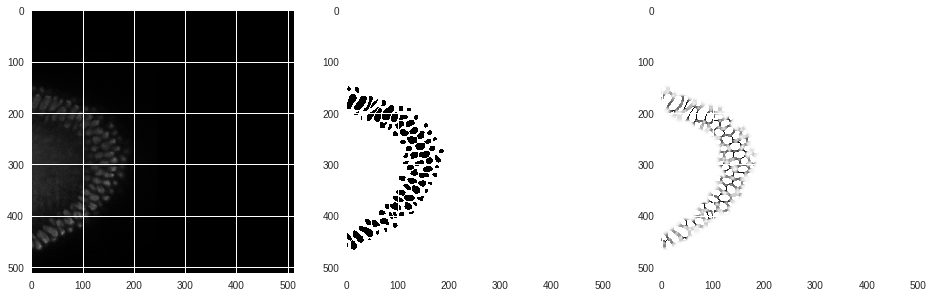

9.899691 1.0 1.1520336


In [100]:
import matplotlib.pyplot as plt
ix_ = np.random.randint(0, len(img_train))

fig = plt.figure(figsize=(16,16))
plt.subplot(1, 3, 1)
plt.imshow(img_train[ix_])
plt.subplot(1, 3, 2)
plt.imshow(gt_train[ix_][...,0])
plt.subplot(1, 3, 3)
plt.imshow(weight_train[ix_][...,0])

plt.show()

print(weight_train[ix_][...,0].max(), weight_train[ix_][...,0].min(), weight_train[ix_][...,0].mean())

In [0]:
import datetime
from keras.optimizers import Adam, SGD

now = datetime.datetime.now()
LOG_DIR = os.path.join(MODEL_DIR, "{}{:%Y%m%dT%H%M}".format(NAME.lower(), now))
checkpoint_path = os.path.join(LOG_DIR, "U_net_{epoch:04d}.h5")

#Model
model = Unet(img_size=412, pad='valid')#crop_size)
model.summary()

#model.compile(optimizer=Adam(lr=0.001), loss=bce_dice_loss, metrics=[mean_iou,KLO.binary_crossentropy])
#model.compile(optimizer=Adam(lr=0.001,clipvalue=5), loss=KLO.binary_crossentropy, metrics=[mean_iou,bce_dice_loss])

# Callbacks
callbacks = [keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=True, write_images=False),
             keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0, period=5, save_weights_only=True)
]

model.fit_generator(train_generator, steps_per_epoch=len(img_train)/batch_size, epochs=600,
                    validation_data=val_generator, validation_steps=len(img_val), initial_epoch=0, callbacks=callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 412, 412, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 412, 412, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 410, 410, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 410, 410, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

56/55 [==============================] - 94s 2s/step - loss: 0.3994 - val_loss: 12.2221
Epoch 2/600
56/55 [==============================] - 82s 1s/step - loss: 0.2058 - val_loss: 0.6674
Epoch 3/600
56/55 [==============================] - 82s 1s/step - loss: 0.1804 - val_loss: 1.5961
Epoch 4/600
56/55 [==============================] - 82s 1s/step - loss: 0.1479 - val_loss: 0.3956
Epoch 5/600
56/55 [==============================] - 82s 1s/step - loss: 0.1325 - val_loss: 0.5769
Epoch 6/600
44/55 [======================>.......] - ETA: 15s - loss: 0.1359

56/55 [==============================] - 82s 1s/step - loss: 0.1291 - val_loss: 0.3123
Epoch 7/600
56/55 [==============================] - 82s 1s/step - loss: 0.1130 - val_loss: 0.3100
Epoch 8/600
56/55 [==============================] - 82s 1s/step - loss: 0.1062 - val_loss: 0.3001
Epoch 9/600
56/55 [==============================] - 82s 1s/step - loss: 0.1062 - val_loss: 0.1676
Epoch 10/600
56/55 [==============================] - 82s 1s/step - loss: 0.1039 - val_loss: 0.3220
Epoch 11/600
49/55 [=========================>....] - ETA: 8s - loss: 0.1135

56/55 [==============================] - 82s 1s/step - loss: 0.1112 - val_loss: 0.2218
Epoch 12/600
56/55 [==============================] - 82s 1s/step - loss: 0.1029 - val_loss: 0.2809
Epoch 13/600
56/55 [==============================] - 82s 1s/step - loss: 0.0975 - val_loss: 0.2485
Epoch 14/600
56/55 [==============================] - 82s 1s/step - loss: 0.0992 - val_loss: 0.2638
Epoch 15/600
56/55 [==============================] - 82s 1s/step - loss: 0.0926 - val_loss: 0.1342
Epoch 16/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0902 

56/55 [==============================] - 82s 1s/step - loss: 0.0888 - val_loss: 0.1739
Epoch 17/600
56/55 [==============================] - 82s 1s/step - loss: 0.0910 - val_loss: 0.1321
Epoch 18/600
56/55 [==============================] - 82s 1s/step - loss: 0.0897 - val_loss: 0.1954
Epoch 19/600
56/55 [==============================] - 82s 1s/step - loss: 0.1025 - val_loss: 1.2664
Epoch 20/600
56/55 [==============================] - 82s 1s/step - loss: 0.1038 - val_loss: 0.2940
Epoch 21/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0890 

56/55 [==============================] - 82s 1s/step - loss: 0.0913 - val_loss: 0.1826
Epoch 22/600
56/55 [==============================] - 82s 1s/step - loss: 0.0911 - val_loss: 0.1632
Epoch 23/600
56/55 [==============================] - 82s 1s/step - loss: 0.0852 - val_loss: 0.1484
Epoch 24/600
56/55 [==============================] - 82s 1s/step - loss: 0.0832 - val_loss: 0.1944
Epoch 25/600
56/55 [==============================] - 82s 1s/step - loss: 0.0823 - val_loss: 0.1724
Epoch 26/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0825 

56/55 [==============================] - 83s 1s/step - loss: 0.0823 - val_loss: 0.1177
Epoch 27/600
56/55 [==============================] - 82s 1s/step - loss: 0.0943 - val_loss: 0.2786
Epoch 28/600
56/55 [==============================] - 82s 1s/step - loss: 0.0867 - val_loss: 0.1255
Epoch 29/600
56/55 [==============================] - 82s 1s/step - loss: 0.0813 - val_loss: 0.3144
Epoch 30/600
56/55 [==============================] - 82s 1s/step - loss: 0.0776 - val_loss: 0.2868
Epoch 31/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0809 

56/55 [==============================] - 82s 1s/step - loss: 0.0797 - val_loss: 0.1718
Epoch 32/600
56/55 [==============================] - 82s 1s/step - loss: 0.0770 - val_loss: 0.1627
Epoch 33/600
56/55 [==============================] - 82s 1s/step - loss: 0.0799 - val_loss: 0.1971
Epoch 34/600
56/55 [==============================] - 82s 1s/step - loss: 0.0784 - val_loss: 0.2798
Epoch 35/600
56/55 [==============================] - 82s 1s/step - loss: 0.0823 - val_loss: 0.2395
Epoch 36/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0790 

56/55 [==============================] - 83s 1s/step - loss: 0.0797 - val_loss: 0.1226
Epoch 37/600
56/55 [==============================] - 82s 1s/step - loss: 0.0812 - val_loss: 0.2461
Epoch 38/600
56/55 [==============================] - 82s 1s/step - loss: 0.0763 - val_loss: 0.2284
Epoch 39/600
56/55 [==============================] - 82s 1s/step - loss: 0.0755 - val_loss: 0.1805
Epoch 40/600
56/55 [==============================] - 82s 1s/step - loss: 0.0732 - val_loss: 0.2630
Epoch 41/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0739 

56/55 [==============================] - 82s 1s/step - loss: 0.0752 - val_loss: 0.3977
Epoch 42/600
56/55 [==============================] - 82s 1s/step - loss: 0.0760 - val_loss: 0.2145
Epoch 43/600
56/55 [==============================] - 82s 1s/step - loss: 0.0790 - val_loss: 0.3115
Epoch 44/600
56/55 [==============================] - 82s 1s/step - loss: 0.0754 - val_loss: 0.1205
Epoch 45/600
56/55 [==============================] - 82s 1s/step - loss: 0.0752 - val_loss: 0.1642
Epoch 46/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0708 

56/55 [==============================] - 82s 1s/step - loss: 0.0724 - val_loss: 0.1039
Epoch 47/600
56/55 [==============================] - 82s 1s/step - loss: 0.0698 - val_loss: 0.1733
Epoch 48/600
56/55 [==============================] - 82s 1s/step - loss: 0.0721 - val_loss: 0.1263
Epoch 49/600
56/55 [==============================] - 82s 1s/step - loss: 0.0722 - val_loss: 0.3056
Epoch 50/600
56/55 [==============================] - 82s 1s/step - loss: 0.0767 - val_loss: 0.2043
Epoch 51/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0761 

56/55 [==============================] - 82s 1s/step - loss: 0.0776 - val_loss: 0.3013
Epoch 52/600
56/55 [==============================] - 82s 1s/step - loss: 0.0757 - val_loss: 0.4027
Epoch 53/600
56/55 [==============================] - 82s 1s/step - loss: 0.0723 - val_loss: 0.1067
Epoch 54/600
56/55 [==============================] - 82s 1s/step - loss: 0.0694 - val_loss: 0.1456
Epoch 55/600
56/55 [==============================] - 82s 1s/step - loss: 0.0694 - val_loss: 0.1065
Epoch 56/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0702 

56/55 [==============================] - 82s 1s/step - loss: 0.0705 - val_loss: 0.1836
Epoch 57/600
56/55 [==============================] - 82s 1s/step - loss: 0.0677 - val_loss: 0.1073
Epoch 58/600
56/55 [==============================] - 82s 1s/step - loss: 0.0749 - val_loss: 2.5737
Epoch 59/600
56/55 [==============================] - 82s 1s/step - loss: 0.0741 - val_loss: 0.3055
Epoch 60/600
56/55 [==============================] - 82s 1s/step - loss: 0.0709 - val_loss: 0.1385
Epoch 61/600
48/55 [=========================>....] - ETA: 9s - loss: 0.0702 

56/55 [==============================] - 82s 1s/step - loss: 0.0691 - val_loss: 0.2586
Epoch 62/600
56/55 [==============================] - 82s 1s/step - loss: 0.0679 - val_loss: 0.1198
Epoch 63/600
56/55 [==============================] - 82s 1s/step - loss: 0.0680 - val_loss: 0.1933
Epoch 64/600
56/55 [==============================] - 82s 1s/step - loss: 0.0674 - val_loss: 0.1780
Epoch 65/600
56/55 [==============================] - 82s 1s/step - loss: 0.0664 - val_loss: 0.1689
Epoch 66/600
35/55 [==================>...........] - ETA: 27s - loss: 0.0683

In [0]:
model.fit_generator(train_generator, steps_per_epoch=len(img_train)/batch_size, epochs=600,
                    validation_data=val_generator, validation_steps=len(img_val)/batch_size, initial_epoch=0, callbacks=callbacks)

In [7]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
  
def rleToMask(rleString,height,width):
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

TEST_DIR = "../DSB2018/stage1_test/"

test_ids = next(os.walk(TEST_DIR))[1]

print(test_ids[:3])

images_path = TEST_DIR + "{}/images/{}.png"

test_df = pd.read_csv('stage1_solution.csv')

test_list = []
test_gt = []
for i,id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    image_path = images_path.format(id_,id_)
    image = cv2.imread(image_path)
    
    df_id = test_df.loc[test_df['ImageId'] == id_]#['EncodedPixels']
    
    masks = np.zeros(image.shape[:2]+(len(df_id),), dtype=np.uint8)
    for j in range(len(df_id)):
        rle = df_id.iloc[j]
        masks[:,:,j] = rleToMask(rle['EncodedPixels'], rle['Height'], rle['Width'])
    masks = masks.astype(np.bool)
    
    test_list.append(image)
    test_gt.append(masks)

    
#for i,test_image in tqdm(enumerate(test_list), total=len(test_list)):
#    if not (test_image[:,:,0]==test_image[:,:,1]).all(): #not gray img
#            temp = 255 - (cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)) #convert to gray 1 channel + invert
#            test_list[i] = cv2.cvtColor(temp,cv2.COLOR_GRAY2BGR) #grayscale 3 channels

['1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c', '912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406', 'df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8']


 12%|█▏        | 8/65 [00:09<01:04,  1.13s/it]/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 65/65 [01:10<00:00,  1.09s/it]


In [82]:
shapes = [img.shape for img in test_list]
a,b=np.unique(shapes, axis=0, return_counts=True)
list(zip(a,b))

[(array([256, 256,   3]), 24),
 (array([260, 347,   3]), 4),
 (array([390, 239,   3]), 1),
 (array([512, 640,   3]), 8),
 (array([512, 680,   3]), 8),
 (array([519, 161,   3]), 2),
 (array([519, 162,   3]), 2),
 (array([519, 253,   3]), 4),
 (array([520, 348,   3]), 4),
 (array([520, 696,   3]), 4),
 (array([524, 348,   3]), 4)]

In [0]:
import skimage.transform
from sliding_window import getIndexForPatches

def predict_sw(image, model, cutoff=0.5, window_size=228, overlap=0.5):
        
    if window_size is None:
        weight = np.ones(image.shape[:2]+(1,),dtype=np.float32)
        res = model.predict([image[np.newaxis], weight[np.newaxis]], verbose=0) #newaxis for batch size=1
        return np.squeeze(res)>cutoff
    
    h,w = image.shape[:2]
    pad_size = 92
    weight = np.ones((window_size,window_size,1),dtype=np.float32)
    
    resized=False
    if image.shape[0]<window_size or image.shape[1]<window_size:
        scale = max(1, window_size / min(h, w))
        #print("1",image.shape,flush=True)
        image = cv2.resize(image, (round(w * scale), round(h * scale)))
        #print("2",image.shape,flush=True)
        resized=True
    
    #print(image.shape,flush=True)
    h2,w2 = image.shape[:2]
    windows = getIndexForPatches(w2, h2, window_size, overlap)
    
    outputs = []
    for window in windows:
        img = image[window]
            
        img_padded = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='reflect')
        
        res = model.predict([img_padded[np.newaxis], weight[np.newaxis]], verbose=0) #newaxis for batch size=1
        res = res[0]#np.squeeze(res)
        
        outputs.append(res)
        
    # merge multiple results
    merged_output = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.float32)
    for window, output in zip(windows, outputs):
        merged_output[window] = np.maximum(output, merged_output[window])
    #merged_output = merged_output.reshape((image.shape[0], image.shape[1]))

    if resized:
        #print("3",merged_output.shape,flush=True)
        merged_output = cv2.resize(merged_output, (w, h))
        #print("4",merged_output.shape,flush=True)
    
    return np.squeeze(merged_output)>cutoff

#print(test_list[1].shape)
#import matplotlib.pyplot as plt
#print(predict_sw(test_list[1],model).shape)
#plt.imshow(predict_sw(test_list[1],model))

In [0]:
from skimage.morphology import label
from scipy.ndimage.morphology import binary_dilation


def tta_predict(image, model, cutoff):
    
    tta_n=8
    voting_threshold = 5
    
    batch_tta = []
 
    #Do augmentations
    batch_tta.append(image)
    batch_tta.append(np.rot90(image, k=1))
    batch_tta.append(np.rot90(image, k=2))
    batch_tta.append(np.rot90(image, k=3))
    batch_tta.append(np.fliplr(image))
    batch_tta.append(np.flipud(image))
    batch_tta.append(np.rot90(np.fliplr(image), k=1))
    batch_tta.append(np.rot90(np.flipud(image), k=1))

    #In case image is too big for memory
    res_predict = []
    for tta_img in batch_tta:
        #tta_weight = np.ones(tta_img.shape[:2]+(1,),dtype=np.float32)
        #res_predict.append(np.squeeze(model.predict([tta_img[np.newaxis], tta_weight[np.newaxis]], verbose=0))>cutoff)
        res_predict.append(predict_sw(tta_img, model, cutoff=cutoff))
    #print(res_predict[0].shape, res_predict[0].dtype, res_predict[0].max(), res_predict[0].min())
    res_predict = [res_pred.astype(np.bool) for res_pred in res_predict]
    res_predict = [res_pred.astype(np.uint8) for res_pred in res_predict]
    
    #Undo augmentations
    res_predict[0] = res_predict[0]
    res_predict[1] = np.rot90(res_predict[1], k=-1)
    res_predict[2] = np.rot90(res_predict[2], k=-2)
    res_predict[3] = np.rot90(res_predict[3], k=-3)
    res_predict[4] = np.fliplr(res_predict[4])
    res_predict[5] = np.flipud(res_predict[5])
    res_predict[6] = np.rot90(np.fliplr(res_predict[6]), k=1)
    res_predict[7] = np.rot90(np.flipud(res_predict[7]), k=1)
    
    res_predict = np.array(res_predict, dtype=np.uint8)
    #Voting
    tta_sum = np.sum(res_predict,axis=0)
    tta_sum = tta_sum>voting_threshold
    
    return tta_sum

def get_predictions(test_list, model, cutoff=0.5, tta=True, pad=16, dilation=True):
    
    test_predictions = []
    for i,image_test in tqdm(enumerate(test_list), total=len(test_list)):
        image = image_test
        
        #Padding64 to avoid max pool errors in unet
        if pad:
            image, window = pad2n(image, pad)
        
        if tta:
            raw_pred = tta_predict(image, model, cutoff)
        else:
            weight = np.ones(image.shape[:2]+(1,),dtype=np.float32)
            
            image  = image[np.newaxis]
            weight = weight[np.newaxis]

            #Predict
            raw_pred = model.predict([image, weight], verbose=0)

            #Squeeze before remove padding 
            raw_pred = np.squeeze(raw_pred)
        
        raw_pred = raw_pred[window]
        
        
        #Label and thresholding
        pred = label(raw_pred > cutoff)
        
        #Mask conversion
        masks = label_to_masks(pred)
        
        #Mask dilation as post processing
        if dilation:
            for j in range(masks.shape[-1]):
                masks[:,:,j] = binary_dilation(masks[:,:,j].astype(np.uint8), iterations=2)
        masks = masks.astype(np.bool)

        test_predictions.append(masks)
        
    return test_predictions

def find_last(NAME, model_dir):
    """Finds the last checkpoint file of the last trained model in the
    model directory.
    Returns:
        log_dir: The directory where events and weights are saved
        checkpoint_path: the path to the last checkpoint file
    """
    # Get directory names. Each directory corresponds to a model
    dir_names = next(os.walk(model_dir))[1]
    key = NAME.lower()
    dir_names = filter(lambda f: f.startswith(key), dir_names)
    dir_names = sorted(dir_names)
    if not dir_names:
        return None, None
    # Pick last directory
    dir_name = os.path.join(model_dir, dir_names[-1])
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("U_net"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        return dir_name, None
    checkpoint = os.path.join(dir_name, checkpoints[-1])
    return dir_name, checkpoint

In [12]:
#Model
model = Unet(img_size=412)

Unet_path = find_last(NAME, MODEL_DIR)[1]
print(Unet_path)

#model.load_weights(Unet_path)
model.load_weights('/content/drive/kaggle/Unet_dsb2018/logs/bowl20180501T1822/U_net_0080.h5')


/content/drive/kaggle/Unet_dsb2018/logs/bowl20180505T1227/U_net_0130.h5


In [13]:
#Evaluation
test_predictions = get_predictions(test_list, model,tta=True, pad=64)

  5%|▍         | 3/65 [00:09<03:09,  3.06s/it]/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 65/65 [06:39<00:00,  6.15s/it]


29


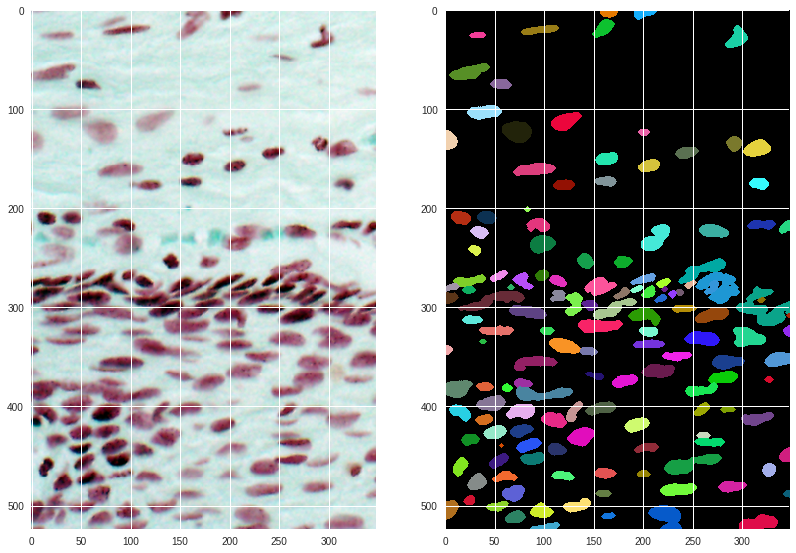

In [14]:
import matplotlib.pyplot as plt
import random

def random_color_img(label):
    image = np.zeros(label.shape + (3,), dtype=np.uint8)
    for i in range(1,label.max()):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        color = np.array([r,g,b])
        image[label==i] = color
    
    return image
        
    

ix_ = np.random.randint(0, len(test_list))
print(ix_)
fig = plt.figure(figsize=(21,21))
plt.subplot(1, 3, 1)
plt.imshow(test_list[ix_])
plt.subplot(1, 3, 2)
plt.imshow(random_color_img(masks_to_label(test_predictions[ix_])))

plt.show()

In [0]:
#Rewriting the mIOU function to account for correct number of ground truth mask
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = masks_to_label(y_true_in)
    y_pred = masks_to_label(y_pred_in)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = len(y_true_in)
    metric = []
    for batch in range(batch_size):
        #print(y_true_in[batch].shape, y_pred_in[batch].shape)
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
#     return np.array(np.mean(metric), dtype=np.float32)
    return metric


In [16]:
mIOU = np.array(iou_metric_batch(test_gt, test_predictions))
print('The mean IOU is {}'.format(np.mean(mIOU)))

The mean IOU is 0.3369854406649563


(256, 256) bool True False
(256, 256) bool True False


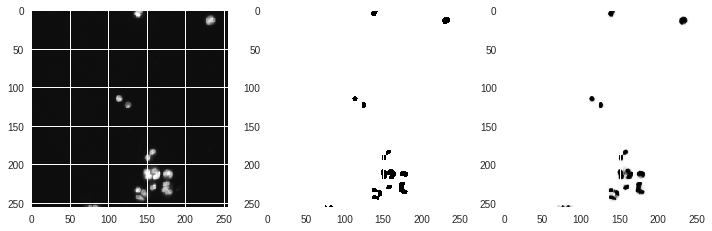

In [0]:
import matplotlib.pyplot as plt
image = test_list[10]

res_tta = tta_predict(image, model,0.5)
print(res_tta.shape, res_tta.dtype, res_tta.max(), res_tta.min())
simage = image[np.newaxis]
#Predict
raw_pred = model.predict(simage, verbose=0) 
raw_pred = np.squeeze(raw_pred)

fig = plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(res_tta)
plt.subplot(133)
plt.imshow(raw_pred)
plt.show()